In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Apr 15 07:26:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    37W / 250W |   3251MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def bootstrap():
  !pip install -U albumentations
  !pip uninstall opencv-python-headless
  !pip install opencv-python-headless==4.5.2.52
  !pip list | grep opencv

  !mkdir -p /content/DataSets/NIHDataSet/
  !mkdir -p /content/DataSets/NIHDataSet/results/saved_images

  !cp /content/drive/MyDrive/Colab\ Notebooks/DataSets/NIHDataSet/images/*.* /content/DataSets/NIHDataSet/
  !cp /content/drive/MyDrive/Colab\ Notebooks/DataSets/NIHDataSet/*.csv /content/DataSets/NIHDataSet/

  !tar -xf '/content/DataSets/NIHDataSet/images_004.tar.gz' -C '/content/DataSets/NIHDataSet/'

bootstrap()



     |████████████████████████████████| 102 kB 12.8 MB/s 
     |████████████████████████████████| 47.8 MB 82.1 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7

In [ ]:
#!mv /content/DataSets/NIHDataSet/images/images/*.* /content/DataSets/NIHDataSet/images/
!ls /content/DataSets/NIHDataSet/images | wc -l

10000


In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd

import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset
import torch.optim as optim

from tqdm import tqdm

import os
import time
from PIL import Image
import sklearn
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


In [4]:
SAMPLE_RATIO = 0.1 # 10%
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_DATA_SET_TYPE = ''
MASK_SUFFIX_NO_EXTN = ''

BASE_DIR = '/content/DataSets/NIHDataSet/' #'/content/drive/MyDrive/Colab Notebooks/DataSets/NIHDataSet/'
IMAGE_DIR = BASE_DIR + "images/"
TRAIN_CSV = "train_" + str(SAMPLE_RATIO) + ".csv"
VALIDATION_CSV = "validation_" + str(SAMPLE_RATIO) + ".csv"


CLASS_LABELS = ['Atelectasis',
                'Cardiomegaly',
                'Effusion',
                'Infiltration',
                'Mass',
                'Nodule',
                'Pneumonia',
                'Pneumothorax',
                'Consolidation',
                'Edema',
                'Emphysema',
                'Fibrosis',
                'Pleural_Thickening',
                'Hernia']
NUM_CLASSES = len(CLASS_LABELS)

# Mean and Standard deviation of Imagenet set
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

"""
define data transforms for images for train and validation dataset
"""
TRANSFORMS = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(IMAGE_HEIGHT),
            transforms.CenterCrop(IMAGE_WIDTH),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        'validation': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
    }

In [ ]:
DEVICE

'cuda'

In [ ]:
def save_df(df, filename):
    df.to_csv(filename, index=False)

def load_dataset(name = 'Chest_XRay_Data_OneHot_Mini10k.csv'):
    return pd.read_csv(BASE_DIR + name)

def generate_train_test_split(image_onehot_df, sample_size = SAMPLE_RATIO):
    print("Length of Original Dataset: " , len(image_onehot_df))
    
    image_onehot_sampled_df = image_onehot_df.sample(frac=sample_size, replace=False, random_state=2022)
    print("Length of Sample Dataset: " , len(image_onehot_sampled_df))
    
    return train_test_split(image_onehot_sampled_df, test_size=0.2, random_state=2022, shuffle=True)

def get_train_test_data(name = 'Chest_XRay_Data_OneHot_Mini10k.csv', sample_ratio = SAMPLE_RATIO):
  image_onehot_df = load_dataset(name)
  train, validation = generate_train_test_split(image_onehot_df)

  save_df(train, BASE_DIR + "train_" + str(sample_ratio) + ".csv")
  save_df(validation, BASE_DIR + "validation_" + str(sample_ratio) + ".csv")
  print(f'Length of Training Dataset: {len(train)}, Length of Validation Dataset: {len(validation)}')

  return train, validation

In [ ]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint " + filename)
    torch.save(state, filename)

def load_checkpoint(model, filename):
    print("=> Loading checkpoint " + filename)
    model.load_state_dict(torch.load(filename)["state_dict"])

In [6]:
def get_model():
    model = models.densenet121(pretrained=True)
    model.classifier = nn.Sequential(nn.Linear(1024, NUM_CLASSES), nn.Sigmoid())
    model.to(DEVICE)
    return model

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(get_model())

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

6968206

In [ ]:
def train2(model, train_dataloader, val_dataloader, optimizer, criterion):
    train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])   
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_row={}
        train_curr_epoch_loss = []

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              loss = criterion(outputs, labels.type(torch.float))

              preds = torch.clone(outputs).detach().cpu().numpy()
              truths = torch.clone(labels).detach().cpu().numpy()

              for idx in range(preds.shape[0]):
                preds[idx, ] = preds[idx, ] > 0.5
              preds = preds.astype(int)

              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            print(labels.shape)
            print(preds.shape)
            running_corrects += np.sum(preds == truths)
            break

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects / len(train_dataloader.dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
        
    return model

In [ ]:
class NIHImageDataset(Dataset): 

    def __init__(self, dataset_csv, transform = None):
        self.transform = transform
        
        self.df = pd.read_csv(BASE_DIR + dataset_csv)
        self.df = self.df.set_index("Image Index")

    def __len__(self):
        """
        Args: None
        Returns : Length of dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(IMAGE_DIR, self.df.index[idx]))
        image = image.convert('RGB')

        label_one_hot = np.zeros(len(CLASS_LABELS), dtype=int)
        for i in range(0, len(CLASS_LABELS)):
            if(self.df[CLASS_LABELS[i].strip()].iloc[idx].astype('int') > 0):
                label_one_hot[i] = self.df[CLASS_LABELS[i].strip()].iloc[idx].astype('int')

        if self.transform is not None:
            image = self.transform(image)

        return (image, label_one_hot) #, self.df.index[idx])

def get_loaders():
    train_dataset = NIHImageDataset(dataset_csv = TRAIN_CSV, transform = TRANSFORMS['train'])
    validation_dataset = NIHImageDataset(dataset_csv = VALIDATION_CSV, transform = TRANSFORMS['validation'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, validation_loader

def get_loaders2():
    train_dataset = NIHImageDataset(dataset_csv = TRAIN_CSV, transform = TRANSFORMS['train'])
    validation_dataset = NIHImageDataset(dataset_csv = VALIDATION_CSV, transform = TRANSFORMS['validation'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataset, train_loader, validation_dataset, validation_loader

In [ ]:
def train0(model, dataloaders, optimizer, criterion):
  since = time.time()
  train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
  val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])   
    
  for epoch in range(NUM_EPOCHS):
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels.type(torch.float))

          if phase == 'train':
            loss.backward()
            optimizer.step()

          preds = torch.clone(outputs).detach().cpu().numpy()
          truths = torch.clone(labels).detach().cpu().numpy()

          for idx in range(preds.shape[0]):
            preds[idx, ] = preds[idx, ] > 0.5
          preds = preds.astype(int)

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += np.sum(preds == truths)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
def train3(model, dataloaders, optimizer, criterion):
  since = time.time()

  stats = pd.DataFrame(np.zeros((NUM_EPOCHS, 6)), columns=["Epoch No", 
                                                           "Train Loss", 
                                                           "Train Accuracy",
                                                           "Validation Loss",
                                                           "Validation Accuracy",
                                                           "Time Elapsed"])

  best_acc = 0.0
  for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      loop = tqdm(dataloaders[phase])
      for batch_idx, (inputs, labels) in enumerate(loop):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels.type(torch.float))

          if phase == 'train':
            loss.backward()
            optimizer.step()

          preds = torch.clone(outputs).detach().cpu().numpy()
          truths = torch.clone(labels).detach().cpu().numpy()

          for idx in range(preds.shape[0]):
            preds[idx, ] = preds[idx, ] > 0.5
          preds = preds.astype(int)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += np.sum(preds == truths)

        loop.set_postfix({'Epoch': epoch,
                          'Phase': phase,
                          'Loss': loss.item(),
                          'Running Loss': running_loss})      
      # End batching 
      
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)
      #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      stats["Epoch No"][epoch] = epoch+1
      if phase == 'train':
        stats["Train Loss"][epoch] = epoch_loss
        stats["Train Accuracy"][epoch] = epoch_acc
      else:
        stats["Validation Loss"][epoch] = epoch_loss
        stats["Validation Accuracy"][epoch] = epoch_acc
        epoch_time_elapsed = time.time() - epoch_start
        stats["Time Elapsed"][epoch] = epoch_time_elapsed
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          # save mode
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer":optimizer.state_dict(),
              }
          save_checkpoint(checkpoint, BASE_DIR + "results/densenet_NIH_best.pth")


      stats.to_csv(BASE_DIR + 'results/summary.csv', index=False)

    # End phase loop
  # End epochs
  time_elapsed = time.time() - since
  print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion):
    import torch.optim as optim
    """
    
    Args:
    model: A CNN model
    train_dataloader: the DataLoader of the training data
    n_epoch: number of epochs to train
    optimizer: optimizer for training
    criterion: Loss function
    Return:
        model: trained model 
    
    """
    
    train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])   
    
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        train_row={}
        train_curr_epoch_loss = []
        for data in train_dataloader:
            inputs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)            
            optimizer.zero_grad()
            y_hat = model(inputs)
            y_hat = y_hat.to(DEVICE)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(DEVICE)
            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            train_curr_epoch_loss.append(loss.cpu().data.numpy())
            
        train_row["Epoch No"] = epoch
        train_row["Loss"] = np.mean(train_curr_epoch_loss)
        train_epochs_loss = train_epochs_loss.append(train_row,ignore_index=True)
        print(f"Epoch {epoch}: Train curr_epoch_loss={np.mean(train_curr_epoch_loss)}")
        
        model.eval()

        val_row={}
        
        val_curr_epoch_loss = []
        for i, data in enumerate(val_dataloader):    
            
            inputs = data[0].to(DEVICE)
            labels = data[1].to(DEVICE)            
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(DEVICE)
            true_labels = labels.cpu().data.numpy()            
            y_hat = model(inputs)
            y_hat = y_hat.to(DEVICE)
            probs = y_hat.cpu().data.numpy()                            
            loss = criterion(y_hat, labels)
            val_curr_epoch_loss.append(loss.cpu().data.numpy())

        val_row["Epoch No"] = epoch
        val_row["Loss"] = np.mean(val_curr_epoch_loss)
        val_epochs_loss = val_epochs_loss.append(val_row,ignore_index=True)
        print(f"Epoch {epoch}: Val curr_epoch_loss={np.mean(val_curr_epoch_loss)}")
        
    return model,train_epochs_loss,val_epochs_loss

Length of Original Dataset:  10000
Length of Sample Dataset:  1000
Length of Training Dataset: 800, Length of Validation Dataset: 200
Epoch 0: Train curr_epoch_loss=0.38482430577278137
Epoch 0: Val curr_epoch_loss=0.2237423062324524
Epoch 1: Train curr_epoch_loss=0.1849249303340912
Epoch 1: Val curr_epoch_loss=0.16684435307979584
Epoch 2: Train curr_epoch_loss=0.1480860561132431
Epoch 2: Val curr_epoch_loss=0.16274404525756836
Epoch 3: Train curr_epoch_loss=0.12417241185903549
Epoch 3: Val curr_epoch_loss=0.15968872606754303
Epoch 4: Train curr_epoch_loss=0.10514749586582184
Epoch 4: Val curr_epoch_loss=0.160086527466774
Epoch 5: Train curr_epoch_loss=0.08815489709377289
Epoch 5: Val curr_epoch_loss=0.1626667082309723
Epoch 6: Train curr_epoch_loss=0.07127277553081512
Epoch 6: Val curr_epoch_loss=0.16611622273921967
Epoch 7: Train curr_epoch_loss=0.06006031855940819
Epoch 7: Val curr_epoch_loss=0.17094987630844116
Epoch 8: Train curr_epoch_loss=0.04904881492257118
Epoch 8: Val curr_epo

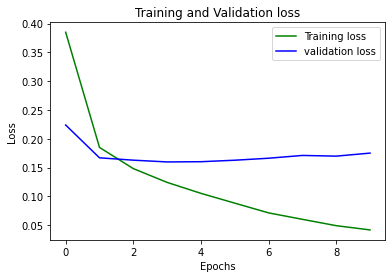

0
160
can't calculate auc for Hernia
Only one class present in y_true. ROC AUC score is not defined in that case.
                 label       auc
0          Atelectasis  0.756793
1         Cardiomegaly  0.407035
2        Consolidation  0.738932
3                Edema  0.952806
4             Effusion  0.661017
5            Emphysema  0.922051
6             Fibrosis  0.587140
7               Hernia       NaN
8         Infiltration  0.681589
9                 Mass  0.632926
10              Nodule  0.620321
11  Pleural_Thickening  0.563077
12           Pneumonia  0.542092
13        Pneumothorax  0.706884


In [ ]:
def main():
  #get_train_test_data()
  train_dataset, train_loader, validation_dataset, validation_loader = get_loaders2()

  dataloaders_dict = {
      'train': train_loader,
      'validation': validation_loader
  }

  model = get_model()
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  model, train_losses, validation_losses = train_model(model, train_loader, validation_loader, optimizer, criterion)
  plot_epoch_loss(train_losses, validation_losses)
  pred_df, true_df = eval_model(model, validation_dataset, validation_loader)
  compute_auc(pred_df, true_df)


  """
  train(model, dataloaders_dict, optimizer, criterion)
  print(pd.read_csv(BASE_DIR + 'results/summary.csv'))
  """

main()



Epoch 0: Train curr_epoch_loss=0.4018988013267517
Epoch 0: Val curr_epoch_loss=0.231360524892807
Epoch 1: Train curr_epoch_loss=0.18967419862747192
Epoch 1: Val curr_epoch_loss=0.17493878304958344
Epoch 2: Train curr_epoch_loss=0.1502361297607422
Epoch 2: Val curr_epoch_loss=0.16285531222820282
Epoch 3: Train curr_epoch_loss=0.1279575675725937
Epoch 3: Val curr_epoch_loss=0.1591566652059555
Epoch 4: Train curr_epoch_loss=0.10704503953456879
Epoch 4: Val curr_epoch_loss=0.1610245704650879
Epoch 5: Train curr_epoch_loss=0.08837063610553741
Epoch 5: Val curr_epoch_loss=0.1629190742969513
Epoch 6: Train curr_epoch_loss=0.07145598530769348
Epoch 6: Val curr_epoch_loss=0.1632796972990036
Epoch 7: Train curr_epoch_loss=0.05987679585814476
Epoch 7: Val curr_epoch_loss=0.1690889149904251
Epoch 8: Train curr_epoch_loss=0.04825887084007263
Epoch 8: Val curr_epoch_loss=0.17061886191368103
Epoch 9: Train curr_epoch_loss=0.04028185456991196
Epoch 9: Val curr_epoch_loss=0.16895045340061188


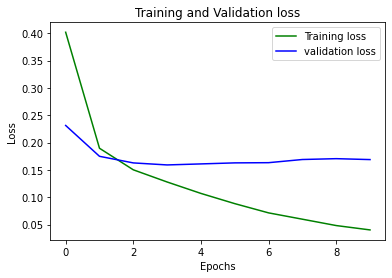

0
160
can't calculate auc for Hernia
Only one class present in y_true. ROC AUC score is not defined in that case.
                 label       auc
0          Atelectasis  0.779212
1         Cardiomegaly  0.542714
2        Consolidation  0.747396
3                Edema  0.946429
4             Effusion  0.751904
5            Emphysema  0.979487
6             Fibrosis  0.541455
7               Hernia       NaN
8         Infiltration  0.710022
9                 Mass  0.645724
10              Nodule  0.638420
11  Pleural_Thickening  0.567179
12           Pneumonia  0.234694
13        Pneumothorax  0.738712


In [ ]:
def main():
  #get_train_test_data()
  train_dataset, train_loader, validation_dataset, validation_loader = get_loaders2()

  dataloaders_dict = {
      'train': train_loader,
      'validation': validation_loader
  }

  model = get_model()
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  model, train_losses, validation_losses = train_model(model, train_loader, validation_loader, optimizer, criterion)
  plot_epoch_loss(train_losses, validation_losses)
  pred_df, true_df = eval_model(model, validation_dataset, validation_loader)
  compute_auc(pred_df, true_df)


  """
  train(model, dataloaders_dict, optimizer, criterion)
  print(pd.read_csv(BASE_DIR + 'results/summary.csv'))
  """

main()



In [ ]:
# models.resnet50(pretrained=True)
model = models.densenet121(pretrained=True)
#model.classifier = nn.Linear(1024, NUM_CLASSES)
model.classifier = nn.Identity()

data = torch.randn((5, 3, 124, 124))
print(data.shape)
model(data).shape

torch.Size([5, 3, 124, 124])


torch.Size([5, 1024])

In [ ]:
def plot_epoch_loss(train_losses, validation_losses):
  loss_train = train_losses['Loss']
  loss_val = validation_losses['Loss']
  epochs = validation_losses['Epoch No']
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def eval_model(model, dataset, dataloader):
    """
    Use the trained/best model and valuate on validation dataset
    Args:
    model: trained model
    dataloader: validation dataloader
    :return:
        Y_pred: prediction of model on the dataloder.
        Y_test: truth labels. 
    """
    model.eval()

    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])
    for i, data in enumerate(dataloader):
        inputs = data[0].to(DEVICE)
        labels = data[1].to(DEVICE)
        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape
        y_hat = model(inputs)
        probs = y_hat.cpu().data.numpy()

        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]


            for k in range(len(CLASS_LABELS)):
                thisrow["prob_" + CLASS_LABELS[k]] = probs[j, k]
                truerow[CLASS_LABELS[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))


    return pred_df, true_df

In [ ]:
def compute_auc(pred_df, true_df):
  """
  Get Prediction and True values for Validation dataset and generate AUC Vaules for Validation dataset
  """
  auc_df = pd.DataFrame(columns=["label", "auc"])

  for column in true_df:

      if column not in [
              'Atelectasis',
              'Cardiomegaly',
              'Effusion',
              'Infiltration',
              'Mass',
              'Nodule',
              'Pneumonia',
              'Pneumothorax',
              'Consolidation',
              'Edema',
              'Emphysema',
              'Fibrosis',
              'Pleural_Thickening',
                  'Hernia']:
          continue
      actual = true_df[column]
      pred = pred_df["prob_" + column]
      thisrow = {}
      thisrow['label'] = column
      thisrow['auc'] = np.nan
      try:
          thisrow['auc'] = sklm.roc_auc_score(
          actual.values.astype(int), pred.values)

          
      except BaseException as e:
          print("can't calculate auc for " + str(column))
          print(e)
      auc_df = auc_df.append(thisrow, ignore_index=True)

  pred_df.to_csv(BASE_DIR + "ResNetSGD-ResNetpreds.csv", index=False)
  auc_df.to_csv(BASE_DIR + "ResNetSGD-ResNetaucs.csv", index=False)
  print(auc_df)
  return auc_df  

In [ ]:
!mkdir -p /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/result1/
!cp -v /content/DataSets/NIHDataSet/results/*.* /content/drive/MyDrive/Colab\ Notebooks/ModelResults/NIHDataSet/result1/

'/content/DataSets/NIHDataSet/results/densenet_NIH_best.pth' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/result1/densenet_NIH_best.pth'
'/content/DataSets/NIHDataSet/results/summary.csv' -> '/content/drive/MyDrive/Colab Notebooks/ModelResults/NIHDataSet/result1/summary.csv'


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/DataSets/NIHDataSet/*.csv /content/DataSets/NIHDataSet/